https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets/data

In [70]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, f1_score, recall_score, roc_auc_score, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay

# Parâmetros iniciais

In [2]:
tipo_transformacao = 'standardization' #'standardization', 'minmax' ou 'robust'
filtrar_bandeira_cartao = False #True ou False

In [3]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

# Carregar dados de transações

In [4]:
df_transactions = pd.read_csv('./Transacoes/transactions_data.csv')

In [5]:
df_transactions.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [6]:
df_transactions.shape

(13305915, 12)

In [7]:
df_transactions.isnull().sum()

id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

# Limpar dados de transações

In [8]:
df_transactions.drop(['date', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'errors'], axis=1, inplace=True)

In [9]:
df_transactions.head()

,id,client_id,card_id,amount,use_chip,merchant_id
0,7475327,1556,2972,$-77.00,Swipe Transaction,59935
1,7475328,561,4575,$14.57,Swipe Transaction,67570
2,7475329,1129,102,$80.00,Swipe Transaction,27092
3,7475331,430,2860,$200.00,Swipe Transaction,27092
4,7475332,848,3915,$46.41,Swipe Transaction,13051


# Carregar dados de usuários

In [10]:
df_users = pd.read_csv('./Transacoes/users_data.csv')

In [11]:
df_users.head()

,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [12]:
df_users.shape

(2000, 14)

In [13]:
df_users.isnull().sum()

id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

# Limpar dados de usuários

In [14]:
df_users.drop(['birth_year', 'birth_month', 'address', 'latitude', 'longitude'], axis=1, inplace=True)

In [15]:
df_users.head()

,id,current_age,retirement_age,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,Female,$29278,$59696,$127613,787,5
1,1746,53,68,Female,$37891,$77254,$191349,701,5
2,1718,81,67,Female,$22681,$33483,$196,698,5
3,708,63,63,Female,$163145,$249925,$202328,722,4
4,1164,43,70,Male,$53797,$109687,$183855,675,1


# Carregar dados de cartões

In [16]:
df_cards = pd.read_csv('./Transacoes/cards_data.csv')

In [17]:
df_cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [18]:
df_cards.shape

(6146, 13)

In [19]:
df_cards.isnull().sum()

id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

# Limpar dados de cartões

In [20]:
df_cards.drop(['card_number', 'expires', 'cvv', 'acct_open_date', 'year_pin_last_changed'], axis=1, inplace=True)

In [21]:
df_cards.head()

,id,client_id,card_brand,card_type,has_chip,num_cards_issued,credit_limit,card_on_dark_web
0,4524,825,Visa,Debit,YES,2,$24295,No
1,2731,825,Visa,Debit,YES,2,$21968,No
2,3701,825,Visa,Debit,YES,2,$46414,No
3,42,825,Visa,Credit,NO,1,$12400,No
4,4659,825,Mastercard,Debit (Prepaid),YES,1,$28,No


# Carregar targets de fraude

In [22]:
targets = json.load(open('./Transacoes/train_fraud_labels.json'))

In [23]:
lista_clientes = []
lista_target = []
for key, value in targets['target'].items():
    lista_clientes.append(key)
    lista_target.append(value)
df_fraud_target = pd.DataFrame({'transaction_id': lista_clientes, 'is_fraud': lista_target})
df_fraud_target['transaction_id'] = df_fraud_target['transaction_id'].astype(int)

In [24]:
df_fraud_target.head()

,transaction_id,is_fraud
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No


In [25]:
df_fraud_target['is_fraud'].value_counts()

is_fraud
No     8901631
Yes      13332
Name: count, dtype: int64

# Juntar os dataframes

In [26]:
df_transactions.head()

,id,client_id,card_id,amount,use_chip,merchant_id
0,7475327,1556,2972,$-77.00,Swipe Transaction,59935
1,7475328,561,4575,$14.57,Swipe Transaction,67570
2,7475329,1129,102,$80.00,Swipe Transaction,27092
3,7475331,430,2860,$200.00,Swipe Transaction,27092
4,7475332,848,3915,$46.41,Swipe Transaction,13051


In [27]:
df_users.head()

,id,current_age,retirement_age,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,Female,$29278,$59696,$127613,787,5
1,1746,53,68,Female,$37891,$77254,$191349,701,5
2,1718,81,67,Female,$22681,$33483,$196,698,5
3,708,63,63,Female,$163145,$249925,$202328,722,4
4,1164,43,70,Male,$53797,$109687,$183855,675,1


In [28]:
df_cards.head()

,id,client_id,card_brand,card_type,has_chip,num_cards_issued,credit_limit,card_on_dark_web
0,4524,825,Visa,Debit,YES,2,$24295,No
1,2731,825,Visa,Debit,YES,2,$21968,No
2,3701,825,Visa,Debit,YES,2,$46414,No
3,42,825,Visa,Credit,NO,1,$12400,No
4,4659,825,Mastercard,Debit (Prepaid),YES,1,$28,No


In [29]:
df_fraud_target.head()

,transaction_id,is_fraud
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No


In [30]:
df = df_transactions.merge(df_fraud_target, left_on='id', right_on='transaction_id', how='left').copy()
df.drop('transaction_id', axis=1, inplace=True)
df = df.merge(df_users, left_on='client_id', right_on='id', how='left').copy()
df.drop(['id_x', 'id_y'], axis=1, inplace=True)
df = df.merge(df_cards.drop('client_id', axis=1), left_on='card_id', right_on='id', how='left').copy()
df.drop(['client_id', 'card_id', 'merchant_id', 'id'], axis=1, inplace=True)
df.dropna(ignore_index=True, inplace=True)

In [31]:
df.head()

,amount,use_chip,is_fraud,current_age,retirement_age,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,has_chip,num_cards_issued,credit_limit,card_on_dark_web
0,$-77.00,Swipe Transaction,No,30,67,Female,$23679,$48277,$110153,740,4,Mastercard,Debit (Prepaid),YES,2,$55,No
1,$14.57,Swipe Transaction,No,48,67,Male,$18076,$36853,$112139,834,5,Mastercard,Credit,YES,1,$9100,No
2,$80.00,Swipe Transaction,No,49,65,Male,$16894,$34449,$36540,686,3,Mastercard,Debit,YES,1,$14802,No
3,$46.41,Swipe Transaction,No,51,69,Male,$33529,$68362,$96182,711,2,Visa,Debit,YES,1,$19113,No
4,$4.81,Swipe Transaction,No,47,65,Female,$25537,$52065,$98613,828,5,Mastercard,Debit (Prepaid),YES,1,$89,No


In [32]:
df.tail()

,amount,use_chip,is_fraud,current_age,retirement_age,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,has_chip,num_cards_issued,credit_limit,card_on_dark_web
8914958,$12.93,Chip Transaction,No,37,68,Male,$11755,$23967,$3880,722,4,Visa,Debit,YES,1,$8333,No
8914959,$67.01,Chip Transaction,No,74,67,Female,$22545,$23011,$30510,721,3,Visa,Debit,YES,2,$24617,No
8914960,$1.11,Chip Transaction,No,81,67,Female,$22681,$33483,$196,698,5,Mastercard,Debit,YES,1,$26743,No
8914961,$12.80,Online Transaction,No,62,66,Male,$9995,$20377,$12092,789,4,Mastercard,Debit,YES,1,$5141,No
8914962,$40.44,Swipe Transaction,No,67,67,Female,$32580,$78329,$40161,720,3,Mastercard,Debit,YES,1,$17686,No


In [33]:
df.shape

(8914963, 17)

# Filtrar a bandeira do cartão para redução de dados

In [34]:
df['card_brand'].value_counts()

card_brand
Mastercard    4795682
Visa          3321615
Amex           572424
Discover       225242
Name: count, dtype: int64

In [35]:
df[['card_brand', 'is_fraud']].groupby('card_brand').value_counts().unstack(fill_value=0)

is_fraud,No,Yes
card_brand,,
Amex,571500,924
Discover,224763,479
Mastercard,4788573,7109
Visa,3316795,4820


In [36]:
if filtrar_bandeira_cartao:
    df = df[df['card_brand'] == 'Amex'].copy()
    df.drop('card_brand', axis=1, inplace=True)
    df.reset_index(drop=True, inplace=True)

In [37]:
df.head()

,amount,use_chip,is_fraud,current_age,retirement_age,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,has_chip,num_cards_issued,credit_limit,card_on_dark_web
0,$-77.00,Swipe Transaction,No,30,67,Female,$23679,$48277,$110153,740,4,Mastercard,Debit (Prepaid),YES,2,$55,No
1,$14.57,Swipe Transaction,No,48,67,Male,$18076,$36853,$112139,834,5,Mastercard,Credit,YES,1,$9100,No
2,$80.00,Swipe Transaction,No,49,65,Male,$16894,$34449,$36540,686,3,Mastercard,Debit,YES,1,$14802,No
3,$46.41,Swipe Transaction,No,51,69,Male,$33529,$68362,$96182,711,2,Visa,Debit,YES,1,$19113,No
4,$4.81,Swipe Transaction,No,47,65,Female,$25537,$52065,$98613,828,5,Mastercard,Debit (Prepaid),YES,1,$89,No


# Limpar $ nas colunas de valores

In [38]:
df['amount'] = df['amount'].apply(lambda x : float(x.removeprefix('$')))
df['per_capita_income'] = df['per_capita_income'].apply(lambda x : float(x.removeprefix('$')))
df['yearly_income'] = df['yearly_income'].apply(lambda x : float(x.removeprefix('$')))
df['total_debt'] = df['total_debt'].apply(lambda x : float(x.removeprefix('$')))
df['credit_limit'] = df['credit_limit'].apply(lambda x : float(x.removeprefix('$')))

In [39]:
df.head()

,amount,use_chip,is_fraud,current_age,retirement_age,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,has_chip,num_cards_issued,credit_limit,card_on_dark_web
0,-77.00,Swipe Transaction,No,30,67,Female,23679.0,48277.0,110153.0,740,4,Mastercard,Debit (Prepaid),YES,2,55.0,No
1,14.57,Swipe Transaction,No,48,67,Male,18076.0,36853.0,112139.0,834,5,Mastercard,Credit,YES,1,9100.0,No
2,80.00,Swipe Transaction,No,49,65,Male,16894.0,34449.0,36540.0,686,3,Mastercard,Debit,YES,1,14802.0,No
3,46.41,Swipe Transaction,No,51,69,Male,33529.0,68362.0,96182.0,711,2,Visa,Debit,YES,1,19113.0,No
4,4.81,Swipe Transaction,No,47,65,Female,25537.0,52065.0,98613.0,828,5,Mastercard,Debit (Prepaid),YES,1,89.0,No


In [40]:
df.shape

(8914963, 17)

# Remover registros com a coluna amount negativa

In [41]:
df = df[df['amount'] >= 0]
df.reset_index(drop=True, inplace=True)

In [42]:
df.head()

,amount,use_chip,is_fraud,current_age,retirement_age,gender,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,card_brand,card_type,has_chip,num_cards_issued,credit_limit,card_on_dark_web
0,14.57,Swipe Transaction,No,48,67,Male,18076.0,36853.0,112139.0,834,5,Mastercard,Credit,YES,1,9100.0,No
1,80.00,Swipe Transaction,No,49,65,Male,16894.0,34449.0,36540.0,686,3,Mastercard,Debit,YES,1,14802.0,No
2,46.41,Swipe Transaction,No,51,69,Male,33529.0,68362.0,96182.0,711,2,Visa,Debit,YES,1,19113.0,No
3,4.81,Swipe Transaction,No,47,65,Female,25537.0,52065.0,98613.0,828,5,Mastercard,Debit (Prepaid),YES,1,89.0,No
4,26.46,Online Transaction,No,56,65,Male,13668.0,27861.0,108313.0,782,5,Mastercard,Debit (Prepaid),YES,1,46.0,No


In [43]:
df.shape

(8472184, 17)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8472184 entries, 0 to 8472183
Data columns (total 17 columns):
 #   Column             Dtype  
---  ------             -----  
 0   amount             float64
 1   use_chip           object 
 2   is_fraud           object 
 3   current_age        int64  
 4   retirement_age     int64  
 5   gender             object 
 6   per_capita_income  float64
 7   yearly_income      float64
 8   total_debt         float64
 9   credit_score       int64  
 10  num_credit_cards   int64  
 11  card_brand         object 
 12  card_type          object 
 13  has_chip           object 
 14  num_cards_issued   int64  
 15  credit_limit       float64
 16  card_on_dark_web   object 
dtypes: float64(5), int64(5), object(7)
memory usage: 1.1+ GB


# Separar colunas

In [45]:
colunas_categoricas = ['use_chip', 'gender', 'card_brand', 'card_type', 'has_chip', 'card_on_dark_web']
coluna_alvo = 'is_fraud'

if filtrar_bandeira_cartao:
    colunas_categoricas.remove('card_brand')

# Pairplot

In [46]:
df.select_dtypes(include=[int, float])

,amount,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit
0,14.57,48,67,18076.0,36853.0,112139.0,834,5,1,9100.0
1,80.00,49,65,16894.0,34449.0,36540.0,686,3,1,14802.0
2,46.41,51,69,33529.0,68362.0,96182.0,711,2,1,19113.0
3,4.81,47,65,25537.0,52065.0,98613.0,828,5,1,89.0
4,26.46,56,65,13668.0,27861.0,108313.0,782,5,1,46.0
...,...,...,...,...,...,...,...,...,...,...
8472179,12.93,37,68,11755.0,23967.0,3880.0,722,4,1,8333.0
8472180,67.01,74,67,22545.0,23011.0,30510.0,721,3,2,24617.0
8472181,1.11,81,67,22681.0,33483.0,196.0,698,5,1,26743.0
8472182,12.80,62,66,9995.0,20377.0,12092.0,789,4,1,5141.0


In [47]:
#sns.pairplot(df.select_dtypes(include=[int, float]))

# Matriz de correlação dos dados

<Axes: >

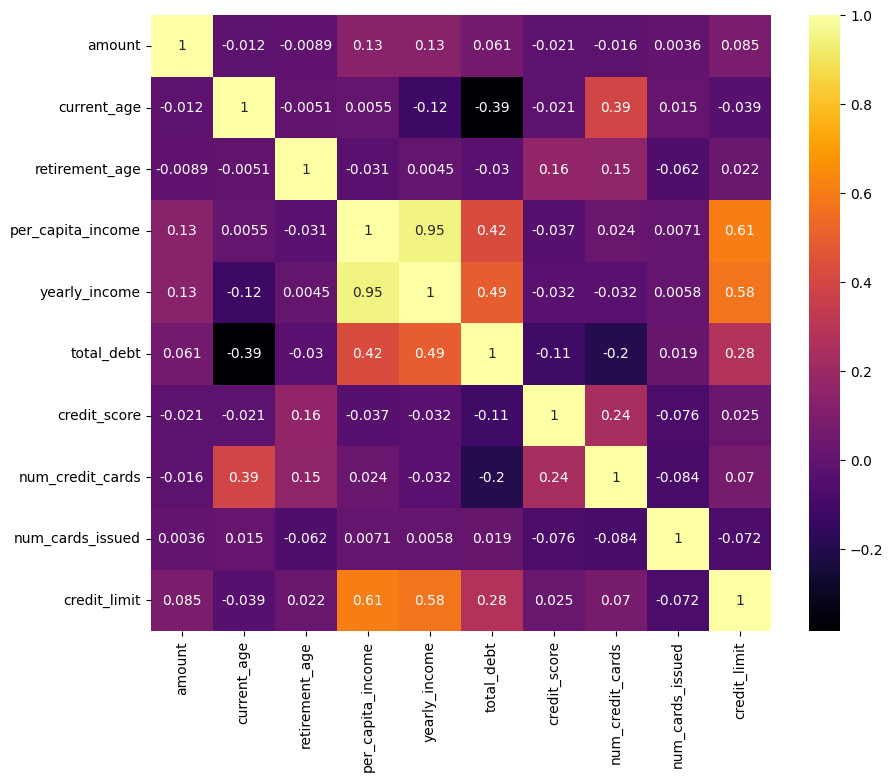

In [48]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=[int, float]).corr(), annot=True, cmap='inferno')

# Aplicar One-Hot-Encoding

In [49]:
df_categoricas = pd.get_dummies(df[colunas_categoricas], drop_first=True, dtype=int).copy()

In [50]:
df_bkp = df.copy()
df.drop(colunas_categoricas, axis=1, inplace=True)
df = pd.concat([df, df_categoricas], axis=1)

In [51]:
df.head()

,amount,is_fraud,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,use_chip_Online Transaction,use_chip_Swipe Transaction,gender_Male,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid),has_chip_YES
0,14.57,No,48,67,18076.0,36853.0,112139.0,834,5,1,9100.0,0,1,1,0,1,0,0,0,1
1,80.00,No,49,65,16894.0,34449.0,36540.0,686,3,1,14802.0,0,1,1,0,1,0,1,0,1
2,46.41,No,51,69,33529.0,68362.0,96182.0,711,2,1,19113.0,0,1,1,0,0,1,1,0,1
3,4.81,No,47,65,25537.0,52065.0,98613.0,828,5,1,89.0,0,1,0,0,1,0,0,1,1
4,26.46,No,56,65,13668.0,27861.0,108313.0,782,5,1,46.0,1,0,1,0,1,0,0,1,1


# Converter coluna alvo

In [52]:
is_fraud = pd.get_dummies(df[coluna_alvo], drop_first=True, dtype=int)
df.drop(coluna_alvo, axis=1, inplace=True)
df['is_fraud'] = is_fraud

In [53]:
df.head()

,amount,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,use_chip_Online Transaction,use_chip_Swipe Transaction,gender_Male,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid),has_chip_YES,is_fraud
0,14.57,48,67,18076.0,36853.0,112139.0,834,5,1,9100.0,0,1,1,0,1,0,0,0,1,0
1,80.00,49,65,16894.0,34449.0,36540.0,686,3,1,14802.0,0,1,1,0,1,0,1,0,1,0
2,46.41,51,69,33529.0,68362.0,96182.0,711,2,1,19113.0,0,1,1,0,0,1,1,0,1,0
3,4.81,47,65,25537.0,52065.0,98613.0,828,5,1,89.0,0,1,0,0,1,0,0,1,1,0
4,26.46,56,65,13668.0,27861.0,108313.0,782,5,1,46.0,1,0,1,0,1,0,0,1,1,0


# Separar os dados em treino e teste

In [54]:
X = df.drop(coluna_alvo, axis=1).copy()
y = df[coluna_alvo].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [55]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Aplicar Scaler aos dados

In [56]:
if tipo_transformacao == 'standardization':
    scaler = StandardScaler()
elif tipo_transformacao == 'minmax':
    scaler = MinMaxScaler()
else:
    scaler = RobustScaler()

In [57]:
data_scaled_train = scaler.fit_transform(X_train.drop(df_categoricas.columns, axis=1))
df_scaled_train = pd.DataFrame(data_scaled_train, columns=X_train.drop(df_categoricas.columns, axis=1).columns)
df_transformed_train = pd.concat([df_scaled_train, X_train[df_categoricas.columns]], axis=1)

data_scaled_test = scaler.transform(X_test.drop(df_categoricas.columns, axis=1))
df_scaled_test = pd.DataFrame(data_scaled_test, columns=X_test.drop(df_categoricas.columns, axis=1).columns)
df_transformed_test = pd.concat([df_scaled_test, X_test[df_categoricas.columns]], axis=1)

In [58]:
df_transformed_train.head()

,amount,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,use_chip_Online Transaction,use_chip_Swipe Transaction,gender_Male,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid),has_chip_YES
0,0.009169,-0.449394,2.377607,-0.235866,-0.143981,-0.260350,-0.321286,-0.540316,-1.010932,-0.174756,0,1,1,0,0,0,0,0,1
1,0.460089,-0.068437,0.421094,0.528120,0.619524,-1.111858,-0.321286,-0.540316,0.929940,-0.141946,0,0,1,0,0,1,0,0,1
2,0.072811,-1.401787,-0.417412,0.021798,0.113407,0.969483,-0.123443,-1.177139,-1.010932,0.066316,0,0,0,0,1,0,1,0,1
3,-0.083376,0.566492,0.421094,-0.712810,-0.620362,-0.662490,-0.321286,0.096507,0.929940,-1.139948,0,0,0,0,1,0,1,0,1
4,0.225606,0.122042,0.700595,9.551505,9.632988,0.645812,0.576613,0.733330,0.929940,6.005275,1,0,0,0,0,1,1,0,1


In [59]:
df_transformed_test.head()

,amount,current_age,retirement_age,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,num_cards_issued,credit_limit,use_chip_Online Transaction,use_chip_Swipe Transaction,gender_Male,card_brand_Discover,card_brand_Mastercard,card_brand_Visa,card_type_Debit,card_type_Debit (Prepaid),has_chip_YES
0,-0.293298,1.582378,-2.653427,-0.222566,-0.593555,-0.705293,-0.945249,0.733330,0.929940,-0.117338,0,1,0,0,0,0,0,0,1
1,-0.507156,-1.655758,-0.417412,-0.649846,-0.557510,0.979159,0.744018,-1.177139,-1.010932,0.197311,0,0,0,0,1,0,1,0,1
2,-0.639868,0.947449,-0.976416,-0.249587,-1.240635,-0.403323,0.287459,-0.540316,0.929940,-1.267415,0,0,1,0,1,0,0,1,1
3,0.667298,-0.639872,-0.137910,-0.500938,-0.408669,0.312138,-2.543205,0.096507,0.929940,-0.443471,0,0,1,0,0,1,1,0,1
4,-0.677320,0.756970,0.700595,-0.406829,-0.314474,0.136173,0.500520,0.096507,0.929940,-0.277288,0,0,0,0,0,1,1,0,1


In [60]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [61]:
y_test.head()

0    0
1    0
2    0
3    0
4    0
Name: is_fraud, dtype: int64

In [62]:
print(f'{df_transformed_train.shape[0]} registros no conjunto de treino e {df_transformed_test.shape[0]} registros no conjunto de teste.')

5930528 registros no conjunto de treino e 2541656 registros no conjunto de teste.


# Ajustar os modelos de Machine Learning

In [63]:
#model = DecisionTreeClassifier(random_state=0)
#model = RandomForestClassifier(random_state=0)
model = GradientBoostingClassifier(random_state=0)

In [64]:
model.fit(df_transformed_train, y_train)

GradientBoostingClassifier(random_state=0)

In [65]:
y_pred_train = model.predict(df_transformed_train)
y_pred_test = model.predict(df_transformed_test)

In [66]:
accuracy_train = np.round(accuracy_score(y_train, y_pred_train),4)
accuracy_test = np.round(accuracy_score(y_test, y_pred_test),4)

In [67]:
print(f'Accuracy no conjunto de treino: {accuracy_train}')
print(f'Accuracy no conjunto de teste: {accuracy_test}')

Accuracy no conjunto de treino: 0.9954
Accuracy no conjunto de teste: 0.9954


In [68]:
print(confusion_matrix(y_test, y_pred_test))

[[2529784    8005]
 [   3647     220]]


In [69]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2537789
           1       0.03      0.06      0.04      3867

    accuracy                           1.00   2541656
   macro avg       0.51      0.53      0.52   2541656
weighted avg       1.00      1.00      1.00   2541656



# MATRIZ DE CONFUSÃO

Text(0, 0.5, 'Classes verdadeiras')

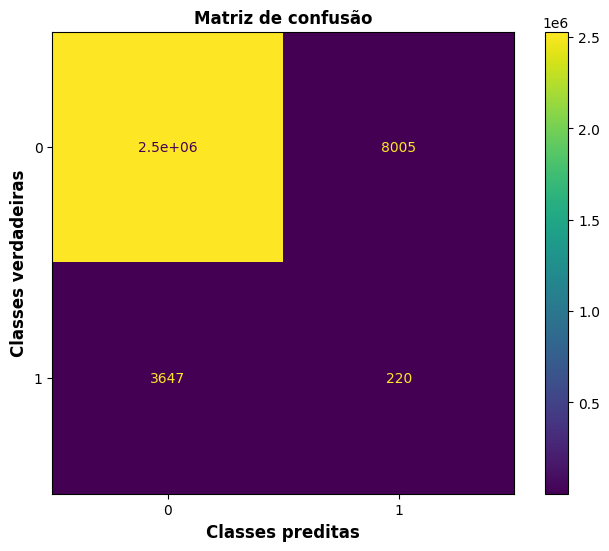

In [72]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(model, df_transformed_test, y_test, ax=ax)
ax.set_title('Matriz de confusão', fontsize=12, fontweight='bold')
ax.set_xlabel('Classes preditas' , fontsize=12, fontweight='bold')
ax.set_ylabel('Classes verdadeiras' , fontsize=12, fontweight='bold')
#fig.savefig('./matriz_confusao_logistic_regression.png', bbox_inches='tight')

# ROC

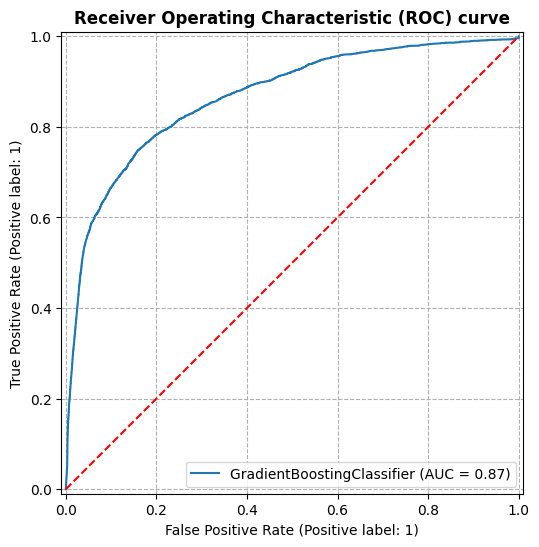

In [71]:
x_diagonal = np.arange(0, 1.1, 0.1)
y_diagonal = np.arange(0, 1.1, 0.1)
fig, ax_roc = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(model, df_transformed_test, y_test, ax=ax_roc)
ax_roc.plot(x_diagonal, y_diagonal, color='r', linestyle='--')
ax_roc.set_title('Receiver Operating Characteristic (ROC) curve', fontsize=12, fontweight='bold')
ax_roc.grid(linestyle='--')
#fig.savefig('./roc_curve_.png', bbox_inches='tight')